<a href="https://colab.research.google.com/github/jan-kreischer/UZH_ML4NLP/blob/main/Project-01/index_jan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 01 - Linear Classification




## Dependencies

In [34]:
!pip install demoji
!pip install alphabet-detector

## Imports

In [8]:
import csv
import re
import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 200)  
pd.set_option('display.max_columns', 200)   
pd.set_option('display.width', 4000) 

from io import StringIO
import requests
import matplotlib.pyplot as plt

import demoji

from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [9]:
url_train_dev = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTOZ2rC82rhNsJduoyKYTsVeH6ukd7Bpxvxn_afOibn3R-eadZGXu82eCU9IRpl4CK_gefEGsYrA_oM/pub?gid=1863430984&single=true&output=tsv'
url_test = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-KNR9nuYatLkSbzSRgpz6Ku1n4TN4w6kKmFLkA6QJHTfQzmX0puBsLF7PAAQJQAxUpgruDd_RRgK7/pub?gid=417546901&single=true&output=tsv'

## Constants

In [10]:
TARGET_COLUMN = 'label'

## 1. Data Acquisition

In [35]:
def load_dataset(url):
    r = requests.get(url)
    data = r.content.decode('utf8')
    df = pd.read_csv(StringIO(data), sep='\t')
    df.columns = ['tweet', 'label']
    return df

In [36]:
training_data = load_dataset(url_train_dev)
test_data = load_dataset(url_test)

In [37]:
dataset = pd.concat([training_data, test_data], axis=0) # Merge into one dataset for the pre-processing

In [38]:
print("The length of the combined dataset is {0} training samples + {1} test samples = {2} samples".format(len(training_data), len(test_data), len(dataset)))

The length of the combined dataset is 52675 training samples + 13279 test samples = 65954 samples


In [39]:
dataset = dataset.sample(frac=1).reset_index(drop=True) # Randomly shuffle the data

In [40]:
dataset.head(10)

,tweet,label
0,@null #V *1001,und
1,Mmm me parece a mi o me duele un poquito la pa...,es
2,@coffee_holicer 그러게요 ㅠㅠ 이걸 어쩐담..,ko
3,@joshua_rpgcs ou une tortue..,fr
4,#1: Handcraft Girls Disney Frozen 7 Pack Panty...,en
5,omg 8 days till US OPEN I'm so excited.,en
6,@Finnertys and that continued every game there...,en
7,"Today stats: One follower, One unfollower via ...",en
8,@minana_nakayama もう冬眠の準備ですか？w( ´艸｀),ja
9,لا إله إلا أنت سبحانك إنى كنت من الظالمين,ar


## 2. Data Exploration

In [65]:
def data_exploration(df):
  '''

  '''
  print('--- {} ---'.format(name))
  n_labels = len(np.unique(df["label"]))
  df = df.sort_values('label')
  print("{0} contains the columns: {1}".format(name, list(df.keys())))
  print("with a total of {} observations".format(len(df)))
  print("and {} different possible labels.".format(n_labels))
  print("The unique labels are {}".format(df["label"].unique()))
  plt.figure(figsize=(15, 3))
  plt.hist(df["label"], bins=n_labels)
  plt.xticks(rotation=90)
  plt.yscale("log")
  plt.xlabel("Language")
  plt.ylabel("#Occurences")
  plt.show()

---  ---
 contains the columns: ['tweet', 'label']
with a total of 65954 observations
and 78 different possible labels.
The unique labels are ['ar' 'ar_LATN' 'az' 'bg' 'bn' 'bs' 'ca' 'cs' 'cy' 'da' 'de' 'dv' 'el'
 'en' 'es' 'et' 'eu' 'fa' 'fi' 'fr' 'gl' 'ha' 'he' 'hi' 'hi-Latn' 'hr'
 'ht' 'hu' 'hy' 'id' 'is' 'it' 'ja' 'ja_LATN' 'jv' 'km' 'ko' 'ko_LATN'
 'la' 'lv' 'mk' 'mn' 'mr' 'ms' 'ne' 'nl' 'no' 'pl' 'ps' 'ps_LATN' 'pt'
 'ro' 'ru' 'si' 'sk' 'sl' 'sq' 'sr' 'su' 'sv' 'sw' 'ta' 'ta_LATN' 'th'
 'tl' 'tn' 'tr' 'uk' 'und' 'ur' 'ur_LATN' 'vi' 'wo' 'xh' 'yo' 'zh-CN'
 'zh-TW' 'zu']


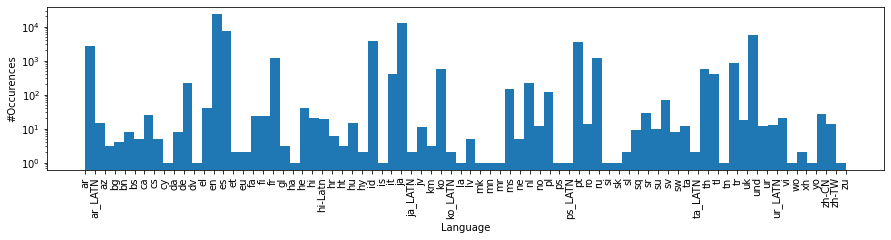

In [42]:
data_exploration(dataset)

In [43]:
dataset.groupby('label').size()

label
ar          2728
ar_LATN       15
az             3
bg             4
bn             8
bs             5
ca            25
cs             5
cy             1
da             8
de           221
dv             1
el            39
en         23266
es          7406
et             2
eu             2
fa            23
fi            23
fr          1170
gl             3
ha             1
he            41
hi            20
hi-Latn       19
hr             6
ht             3
hu            15
hy             2
id          3823
is             1
it           415
ja         12899
ja_LATN        2
jv            11
km             3
ko           568
ko_LATN        2
la             1
lv             5
mk             1
mn             1
mr             1
ms           150
ne             5
nl           225
no            12
pl           119
ps             1
ps_LATN        1
pt          3577
ro            14
ru          1221
si             1
sk             1
sl             2
sq             9
sr            29
su      

## 3. Text Cleaning

This is generally a good idea as many text classification tools rely on counting the occurrences of words. If both upper and lower case versions of the same word are found in the text then the algorithm will count them as different words even though the meaning is the same. Of course this does mean that where the capitalised versions of a word exists, that does have a different meaning. For example the company Apple vs the fruit apple. This could result in poorer performance for some data sets. This is one area of NLP where you may try different methods to see how they affect the overall performance of the model.

In [44]:
def remove_all_emojis(text):
  dem = demoji.findall(text)
  for item in dem.keys():
    text = text.replace(item, '')
  return text

In [45]:
def clean_data(df, column):
    df = df.copy(deep=True) # Make deep copy of tweets
    df[column] = df[column].str.lower() # Transform into all lowercase
    
    patterns = []
    retweet_pattern = '^RT'
    patterns.append(retweet_pattern)
    xml_pattern = '&\S+;'
    patterns.append(xml_pattern)
    hashtag_pattern = '#[A-Za-z0-9_]+'
    patterns.append(hashtag_pattern)
    twitter_mention_pattern = '@[A-Za-z0-9_]+'
    patterns.append(twitter_mention_pattern)
    http_pattern = 'http\S+'
    patterns.append(http_pattern)
    www_pattern = 'www\S+'
    patterns.append(www_pattern)
    tab_pattern = '\t'
    patterns.append(tab_pattern)
    punctuation_pattern = '[!"#$%&\\()*+,-./:;<=>?@\[\]^_`\'{}~]+'
    patterns.append(punctuation_pattern)
    numeric_pattern = '[0-9]+'
    patterns.append(numeric_pattern)
    regex = "|".join(patterns)

    #df[column] = df[column].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem)) 
    df[column] = df[column].apply(lambda elem: re.sub(r"{}".format(regex), "", elem))
    df[column] = df[column].apply(remove_all_emojis)
    
    return df

In [47]:
# Now we want to find out which special characters need to be removed from tweets in order to make the prediction better.
# We go over the printed list an not down the symbold which are not needed for language identification.
# These will be removed in a later step.
languages = list(np.unique(test_data['label']))
for language in languages:
  localized_tweets = training_data[training_data['label'] == language]
  # Clean and compare them
  cleaned_localized_tweets = clean_data(localized_tweets, 'tweet')
  comparison_view = pd.concat([localized_tweets.drop(['label'], axis=1), cleaned_localized_tweets], axis=1)
  print(comparison_view.head(5))
  #print(localized_tweets.head(5))
  print("---")

# Symbols like @<mention>, #, http://link !, numeric values (e.g 16000), " do not help for language identification.

                                               tweet                                              tweet label
0  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...  يا من أناديها ويخنقني البكاء  ويكاد صمت الدمع ...    ar
1  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...  فيه فرق بين اهل غزة اللى مطحونين من ناحيتين وب...    ar
2  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...  ﻋﻦ ﺍﻟﻠﺤﻈﺔ اﻟﺤﻠﻮﺓﺓ ﺍﻟﻠﻲ ﺑﺘﻐﻤﺾ ﻓﻴﻬﺎ ﻋﻴﻨﻴﻚ ﺑﺘﻔﻜﺮ ...    ar
3                                  يا ابو سلو عرفتني                                  يا ابو سلو عرفتني    ar
4  ب50 ريال أكفل معتمر في رمضان ، ولك بإذن الله م...  ب ريال أكفل معتمر في رمضان ، ولك بإذن الله مثل...    ar
---
                                         tweet                            tweet    label
2199                      ya allah ya allah x)              ya allah ya allah x  ar_LATN
2200                   Ya rab tekhlas hel game          ya rab tekhlas hel game  ar_LATN
2201                           Istaqfurullah 😂                   ista

In [48]:
cleaned_dataset = clean_data(dataset, "tweet")

In [49]:
pd.concat([dataset.drop(['label'], axis=1), cleaned_dataset], axis=1).sample(20, axis=0)

,tweet,tweet,label
6584,@svndrey what?¿??,what¿,en
35313,@lespros_naosuke 断捨離かぁ…いいなぁ 今度コツ教えてくれなよ… 無駄なも...,断捨離かぁ…いいなぁ 今度コツ教えてくれなよ… 無駄なものに囲まれてる気がする…๑╯ﻌ╰๑,ja
61100,7/8.14 😈,,und
61792,@sekarang #Xver jam 08:55:18 || zz_oliver,jam || zzoliver,und
61037,@kaiwebb2: 👌 http://t.co/jyp07seNxE,,und
31503,@yahirollen 起きてるほうがよさそ,起きてるほうがよさそ,ja
40713,"Ayy margarita, ay margarita &lt;33 http://t.co...",ayy margarita ay margarita,es
37034,“@AkalaNay_: @TooXclusive_ WE don't like her! ...,“ we dont like her ”dont b mean lol you the d...,en
20851,稽古によってできた手のひらのまめタコをことりに絶妙な力加減でコリコリされる園田ｳﾐﾁｪｧﾝの...,稽古によってできた手のひらのまめタコをことりに絶妙な力加減でコリコリされる園田ｳﾐﾁｪｧﾝの...,ja
35831,@_cramos26 lmao yea nigga you got to do whatch...,lmao yea nigga you got to do whatchu gotta do...,en


# 4.Data Augmentation

## 4.1 Back translation

In [ ]:
! pip install transformers
! pip install mosestokenizer
! pip install SentencePiece

In [ ]:
import transformers, mosestokenizer

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

# Helper function to download data for a language
def download(model_name):
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model



# download model for English -> Romance
#tmp_lang_tokenizer, tmp_lang_model = download('Helsinki-NLP/opus-mt-en-ROMANCE')
# download model for Romance -> English
#src_lang_tokenizer, src_lang_model = download('Helsinki-NLP/opus-mt-ROMANCE-en')



def translate(texts, model, tokenizer, language):
    """Translate texts into a target language"""
    # Format the text as expected by the model
    formatter_fn = lambda txt: f"{txt}" if language == "en" else f">>{language}<< {txt}"
    original_texts = [formatter_fn(txt) for txt in texts]

    # Tokenize (text to tokens)
    tokens = tokenizer.prepare_seq2seq_batch(original_texts)

    # Translate
    translated = model.generate(**tokens)

    # Decode (tokens to text)
    translated_texts = tokenizer.batch_decode(translated, skip_special_tokens=True)

    return translated_texts


def back_translate(texts, language_src, language_dst):
    """Implements back translation"""
    # Translate from source to target language
    translated = translate(texts, tmp_lang_model, tmp_lang_tokenizer, language_dst)

    # Translate from target language back to source language
    back_translated = translate(translated, src_lang_model, src_lang_tokenizer, language_src)

    return back_translated




In [ ]:
model_name = 'Helsinki-NLP/opus-mt-aav-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
tokenizer.supported_language_codes

In [ ]:
language_code_list =df_train_dev['label'].unique

def get_one_language_data(df, n):
  #get the n'th set of language from df_train_dev
  df_one_lang=df[df['label'].isin([language_code_list[n]])]
  return df_one_lang

def generate_new_rows(df_one_lang):
  lable=df_one_lang['label']
  df_one_lang_new = pd.DataFrame(columns=['text','label'])
  for rows in df_one_lang.itterows():
    new_lang = back_translate(df_one_lang['text'],label,'en')
    df_one_lang_new.append({'text':new_lang,'label'label})
    df_one_lang=df_one_lang.append(df_one_lang_new)
  return df_one_lang

def augdata_by_back_translation(df):
  df_new = pd.DataFrame(columns=['text','label'])
  for n in range(0,len(language_code_list)):
    df_one_lang_new = generate_new_rows(get_one_language_data(df,n))
    df_new = df_new.append(df_one_lang_new)
  return df_new



![back_translation.png](attachment:back_translation.png)

# 5.Pre-Processing

# 6.Feature Engineering


In [50]:
def detect_alphabet(df, column):
  df['alphabet'] = df[column].apply(lambda tweet: list(ad.detect_alphabet(tweet)))
  mlb = MultiLabelBinarizer()
  df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('alphabet')),
                            columns=mlb.classes_,
                            index=df.index))
  return df

In [51]:
dataset_w_alphabet = detect_alphabet(dataset, 'tweet')

In [52]:
dataset_w_alphabet.head(10)

,tweet,label,ANGSTROM,ARABIC,ARMENIAN,BENGALI,BLACK-LETTER,BOPOMOFO,CANADIAN,CARON,CJK,CYRILLIC,DEVANAGARI,FEMININE,FULLWIDTH,GEORGIAN,GREEK,GUJARATI,GURMUKHI,HALFWIDTH,HANGUL,HEBREW,HIRAGANA,IDEOGRAPHIC,KANNADA,KATAKANA,KATAKANA-HIRAGANA,KHMER,LAO,LATIN,MASCULINE,MICRO,MODIFIER,ORIYA,SCRIPT,SINHALA,TAMIL,TELUGU,THAI,TIBETAN,YI
0,@null #V *1001,und,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Mmm me parece a mi o me duele un poquito la pa...,es,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,@coffee_holicer 그러게요 ㅠㅠ 이걸 어쩐담..,ko,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,@joshua_rpgcs ou une tortue..,fr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,#1: Handcraft Girls Disney Frozen 7 Pack Panty...,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,omg 8 days till US OPEN I'm so excited.,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,@Finnertys and that continued every game there...,en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7,"Today stats: One follower, One unfollower via ...",en,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,@minana_nakayama もう冬眠の準備ですか？w( ´艸｀),ja,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,لا إله إلا أنت سبحانك إنى كنت من الظالمين,ar,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
print(dataset.shape)
print(dataset_w_alphabet.shape)

(65954, 2)
(65954, 41)


# 7.Modeling 

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
def train_val_test_split(X, y, test_size=0.3, val_size=1/3):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size, shuffle=True)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [56]:
X = dataset_w_alphabet.drop([TARGET_COLUMN, 'tweet'], axis=1)
y = dataset_w_alphabet[TARGET_COLUMN]
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

## 7.1 SGDClassifier

In [57]:
from sklearn.linear_model import SGDClassifier

In [64]:
#Trying different Loss functions, regularisation techniques, early stopping and class imbalance mitigation
parameters = {'class_weight':['balanced', None],
              'penalty': ['l2', 'l1', 'elasticnet'],
              'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
              'early_stopping': [True, False]
              }

sgd_clf = GridSearchCV(SGDClassifier(max_iter=1000, tol=0.01), parameters)
sgd_clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

  FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

  FitFailedWarning)
/usr/local/lib/pytho

KeyboardInterrupt: ignored

In [32]:
sgd_clf = SGDClassifier()
sgd_clf.set_params(**clf.best_params_)
sgd_clf.fit(X_train, y_train)

NameError: ignored

In [32]:


y_pred = sgdc.predict(X_test)

array([[558,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   3,   0],
       [  0,   0,   0, ...,   0,   4,   0]])

In [33]:
classification_report(y_test, y_pred)


              precision    recall  f1-score   support

          ar       0.97      1.00      0.98       559
     ar_LATN       0.00      0.00      0.00         2
          az       0.00      0.00      0.00         1
          bg       0.00      0.00      0.00         2
          bn       1.00      1.00      1.00         2
          bs       0.00      0.00      0.00         1
          ca       0.00      0.00      0.00         6
          da       0.00      0.00      0.00         1
          de       0.00      0.00      0.00        50
          el       0.48      1.00      0.65        10
          en       0.00      0.00      0.00      4623
          es       0.00      0.00      0.00      1491
          fa       0.00      0.00      0.00         6
          fi       0.00      0.00      0.00         4
          fr       0.00      0.00      0.00       214
          gl       0.00      0.00      0.00         2
          ha       0.00      0.00      0.00         1
          he       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
accuracy_score(y_test, y_pred)

0.3292396330831628

## MultinomialNB

In [35]:
mnb_clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6277007050261542

In [39]:
clf.best_params_

{'class_weight': None, 'max_iter': 1000, 'penalty': 'elasticnet', 'tol': 0.01}

In [3]:
sgd_clf.cv_results_

NameError: ignored

In [43]:
y_pred = sgd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.632249260859677

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
estimator = MultinomialNB()
clf = GridSearchCV(estimator, parameters)

In [46]:
clf.best_params_

AttributeError: ignored

In [1]:
clf.cv.results_

NameError: ignored

#8.Evaluation

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()

In [21]:
texts_jp = [
    "ペニーは鮮やかな青い魚を買った。",
    "ペニーは明るい青とオレンジの魚を買った。",
    "猫は店で魚を食べました。",
    "ペニーは店に行きました。ペニーは虫を食べました。ペニーは魚を見ました。",
    "ペニーは魚です"
]

In [22]:
X_train_counts = count_vect.fit_transform(texts_jp)  # num_docs x num_words

In [25]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
matrix = vectorizer.fit_transform(texts_jp)

words_df = pd.DataFrame(matrix.toarray(),
                        columns=vectorizer.get_feature_names())
words_df

,ペニーは店に行きました,ペニーは明るい青とオレンジの魚を買った,ペニーは虫を食べました,ペニーは魚です,ペニーは魚を見ました,ペニーは鮮やかな青い魚を買った,猫は店で魚を食べました
0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1
3,1,0,1,0,1,0,0
4,0,0,0,1,0,0,0
